In [2]:
!git clone https://github.com/damiankucharski/Hyperspectral-Analysis.git
!pip install minisom

fatal: destination path 'Hyperspectral-Analysis' already exists and is not an empty directory.


In [3]:
import os

In [4]:
os.listdir()

['.config', 'Hyperspectral-Analysis', 'sample_data']

In [5]:
os.chdir('Hyperspectral-Analysis')

In [80]:
from net import OurNet
from utils import *
from random import shuffle
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from minisom import MiniSom    

In [7]:
X,y = loadData("IP")

In [8]:
K=30 
EPOCHS = 50
X,pca = applyPCA(X,numComponents=K)
X,y = torch.Tensor(X.astype(int)), torch.Tensor(y.astype(int))
X = scaler(X)
X,y = create_dataset(X,y, window_size=25)

In [9]:
X.shape

torch.Size([21025, 25, 25, 30])

In [26]:
from sklearn.cluster import AgglomerativeClustering

In [28]:
import scipy.cluster.hierarchy as shc

In [30]:
import random
random.seed(200)
y = y.long()
indices = list(range(len(y)))
shuffle(indices)
X_ = X[indices,:]
y_ = y[indices]
split_index = int(len(X)*0.4)
X_train, X_test, y_train, y_test = X_[:split_index],X[split_index:],y_[:split_index],y[split_index:]

In [31]:
threes_ = X_[y_ == 3]
threes_shape = threes_.shape

In [32]:
threes_shape

torch.Size([830, 25, 25, 30])

In [33]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
predictions = cluster.fit_predict(threes_.reshape(830,-1))

In [34]:
sum(predictions)/len(predictions)

0.3253012048192771

In [35]:
from collections import namedtuple

In [36]:
Data_tuple = namedtuple('Data_tuple', ['X', 'y', 'original_shape', 'label'])

In [37]:
data_tuples = []
for i in tqdm.tqdm(range(17)):
  X_part = X_[y_ == i]
  data_tuples.append(Data_tuple(X_part.reshape(X_part.shape[0],-1), y_[y_ == i], X_part.shape, i))

100%|██████████| 17/17 [00:01<00:00, 14.48it/s]


  0%|          | 0/16 [00:00<?, ?it/s]

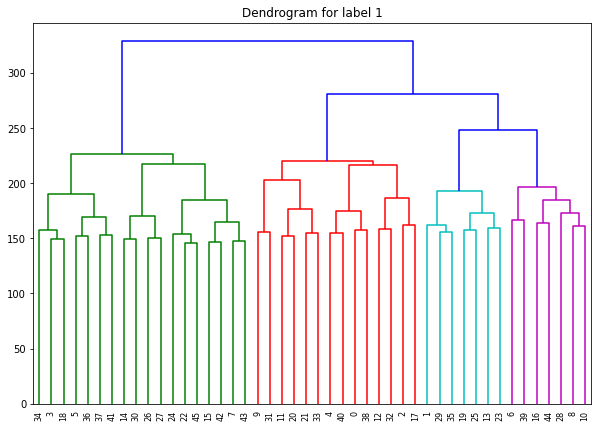

  6%|▋         | 1/16 [00:00<00:08,  1.83it/s]

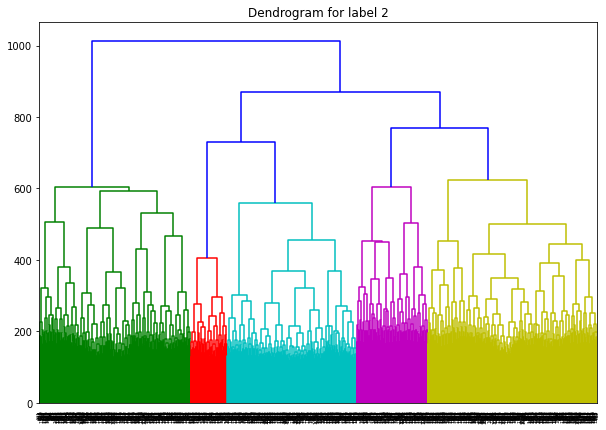

 12%|█▎        | 2/16 [00:49<03:30, 15.07s/it]

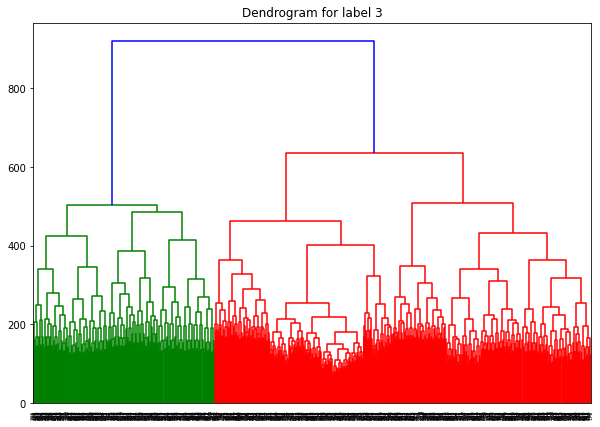

 19%|█▉        | 3/16 [01:12<03:48, 17.58s/it]

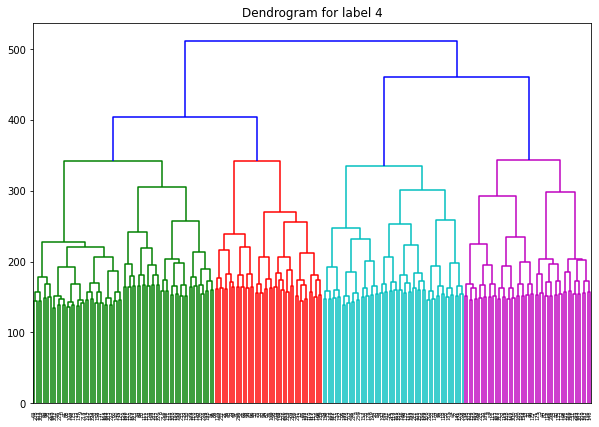

 25%|██▌       | 4/16 [01:18<02:47, 13.93s/it]

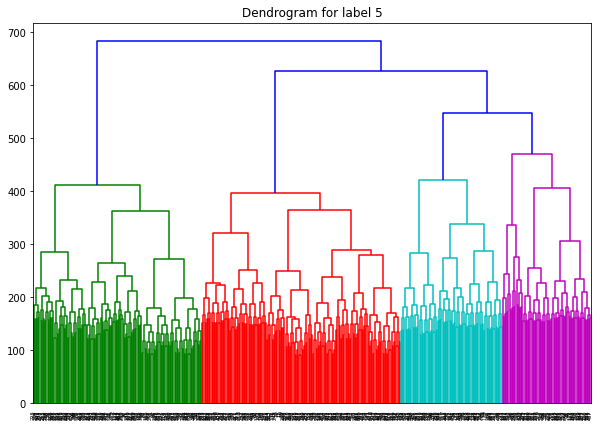

 31%|███▏      | 5/16 [01:30<02:28, 13.52s/it]

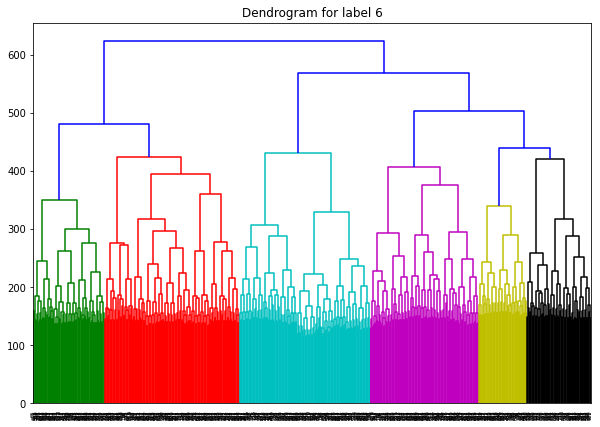

 38%|███▊      | 6/16 [01:51<02:35, 15.55s/it]

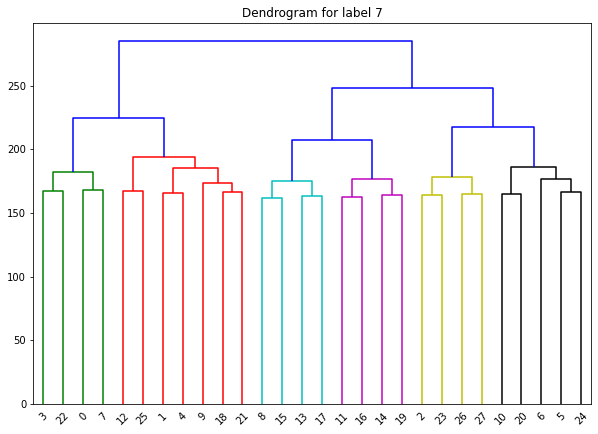

 44%|████▍     | 7/16 [01:51<01:39, 11.00s/it]

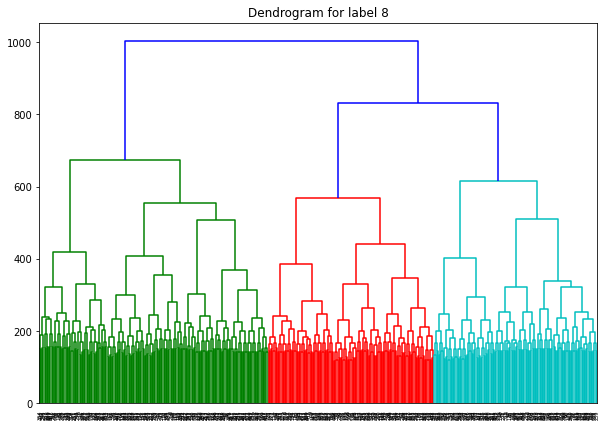

 50%|█████     | 8/16 [02:03<01:30, 11.28s/it]

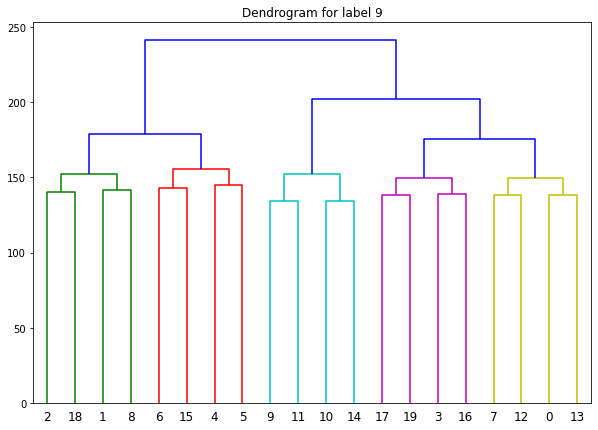

 56%|█████▋    | 9/16 [02:03<00:55,  7.99s/it]

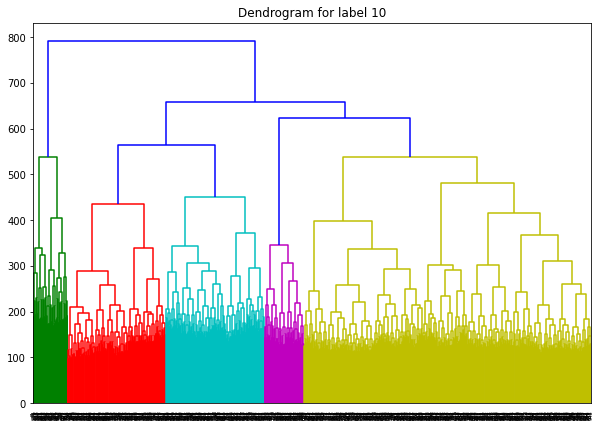

 62%|██████▎   | 10/16 [02:33<01:26, 14.39s/it]

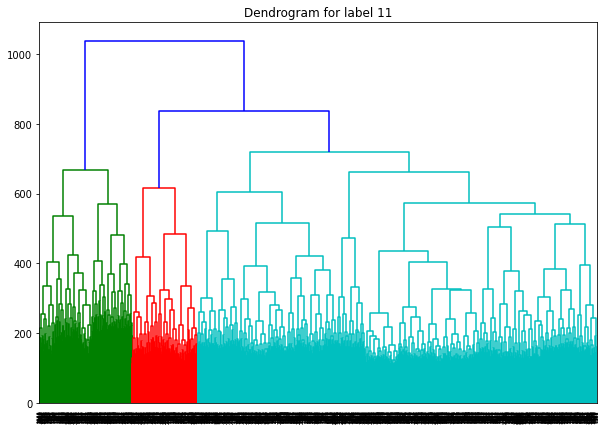

 69%|██████▉   | 11/16 [04:22<03:34, 42.80s/it]

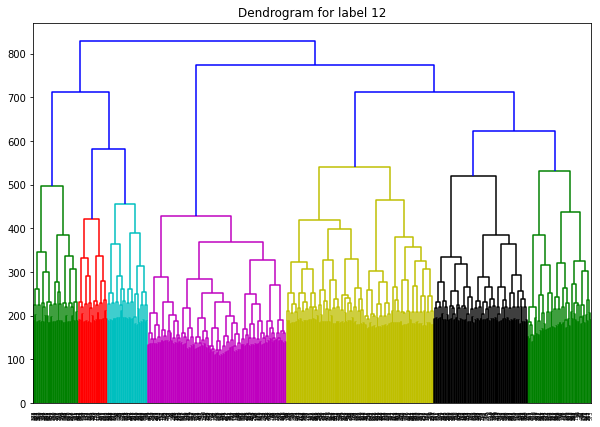

 75%|███████▌  | 12/16 [04:37<02:18, 34.59s/it]

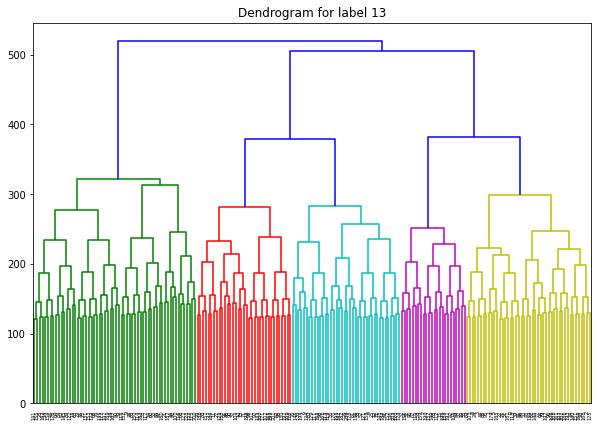

 81%|████████▏ | 13/16 [04:42<01:16, 25.59s/it]

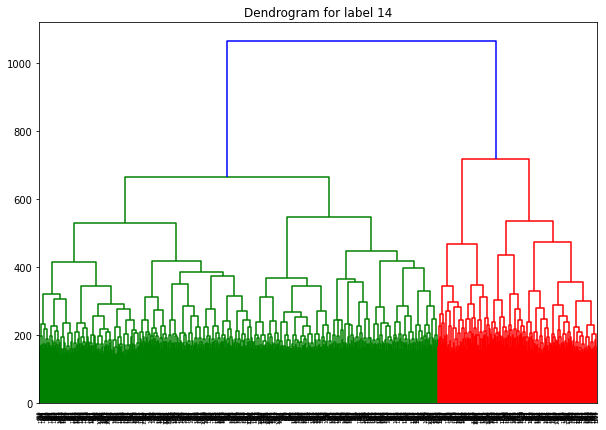

 88%|████████▊ | 14/16 [05:23<01:00, 30.30s/it]

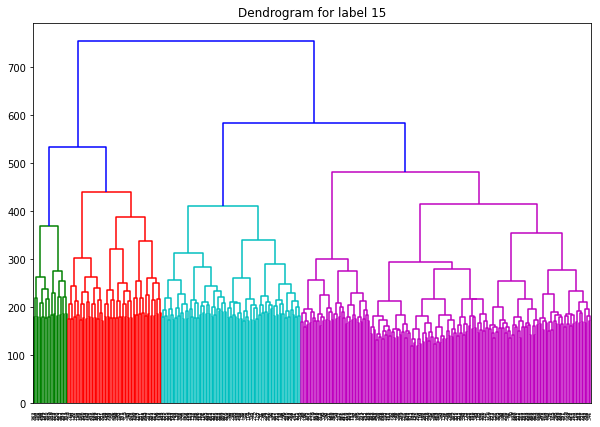

 94%|█████████▍| 15/16 [05:32<00:23, 23.99s/it]

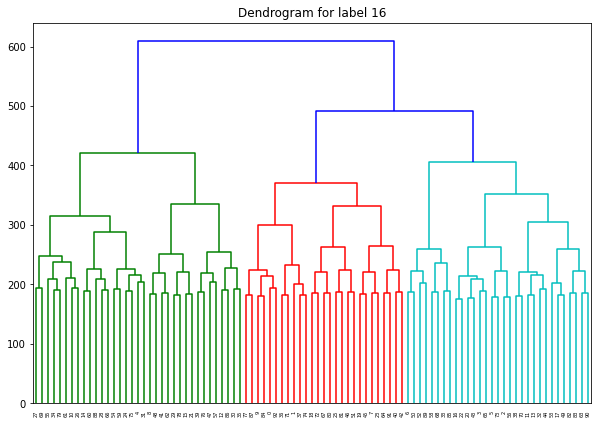

100%|██████████| 16/16 [05:35<00:00, 20.94s/it]


In [38]:
for data_tuple in tqdm.tqdm(data_tuples[1:]):
  plt.figure(figsize=(10, 7))
  plt.title("Dendrogram for label {}".format(data_tuple.label))
  dend = shc.dendrogram(shc.linkage(data_tuple.X, method='ward'))
  plt.show()

In [40]:
# It may be good to find clusters or combinations of clusters that are similar to each other and that make up around 30%-40% of data from given class to make the train set

In [74]:
data_split_tuple = namedtuple('data_split_tuple', ['label','n_clusters','chosen_clusters'])

split_tuples = [
                
data_split_tuple(1,4,[1]),
data_split_tuple(2,5,[1]),
data_split_tuple(3,2,[1]),
data_split_tuple(4,4,[4]),
data_split_tuple(5,4,[1]),
data_split_tuple(6,6,[3]),
data_split_tuple(7,6,[5,6]),
data_split_tuple(8,3,[1]),
data_split_tuple(9,5,[1,2]),
data_split_tuple(10,5,[2,3]),
data_split_tuple(11,3,[1,2]),
data_split_tuple(12,7,[1,2,3]),
data_split_tuple(13,5,[1]),
data_split_tuple(14,2,[2]),
data_split_tuple(15,4,[1,2]),
data_split_tuple(16,3,[1]),

]

train_test_tuple = namedtuple('train_test_tuple', ['label','train_set','test_set'])

train_test_tuples = []


In [75]:
for split_tuple in tqdm.tqdm(split_tuples):
  to_cluster = X_[y_ == split_tuple.label]
  linkage = shc.linkage(to_cluster.reshape(to_cluster.shape[0],-1), method='ward')
  predictions = shc.fcluster(linkage, t=split_tuple.n_clusters, criterion = 'maxclust')
  indices_train = np.in1d(predictions, split_tuple.chosen_clusters)
  train_test_tuples.append(train_test_tuple(label = split_tuple.label, train_set = to_cluster[indices_train,:], test_set = to_cluster[[not _ for _ in indices_train],:]))

100%|██████████| 16/16 [02:07<00:00,  7.99s/it]


In [79]:
train_test_tuples[0].train_set.shape, train_test_tuples[0].test_set.shape

(torch.Size([18, 25, 25, 30]), torch.Size([28, 25, 25, 30]))

In [86]:
class HyperDataset(Dataset):

  def __init__(self, train_test_tuples, train = True):
    self.y = []
    self.X = []
    self.train = train
    for train_test_tuple in train_test_tuples:
      X_temp = train_test_tuple.train_set if train else train_test_tuple.test_set
      self.X.append(X_temp)
      self.y.extend([train_test_tuple.label for i in range(X_temp.shape[0])])
    self.y = torch.Tensor(self.y)
    self.X = torch.cat(self.X)
  
  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, ndx):
    return tuple([self.X[ndx,:], self.y[ndx]])



In [88]:
train_set = HyperDataset(train_test_tuples, train = True)
test_set = HyperDataset(train_test_tuples, train = False)

In [91]:
torch.save(train_set, '/content/drive/MyDrive/DataML/HyperspectralData/train_set.pt')
torch.save(test_set, '/content/drive/MyDrive/DataML/HyperspectralData/test_set.pt')

In [92]:
zero_label = X_[y_ == 0]

In [97]:
torch.save(zero_label, '/content/drive/MyDrive/DataML/HyperspectralData/test_set.pt')

In [98]:
len(train_set), len(test_set), zero_label.shape[0]

(2965, 7284, 10776)

In [101]:
assert X_.shape[0] == sum((len(train_set), len(test_set), zero_label.shape[0]))